In [10]:
import pandas as pd
import numpy as np
import csv
import random
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
# train = pd.read_csv('user_item_review_merge_table.csv')
data = pd.read_csv('for_reviews_acc.csv').dropna()
data.head(5)

,user_id,item_id,playtime_forever,play_after_buy,review,fix_recommend,review_label
0,76561197970982479,22200,271,True,It's unique and worth a playthrough.,True,1
1,76561197970982479,1250,10006,True,Simple yet with great replayability. In my opi...,True,1
2,76561197970982479,43110,834,True,Great atmosphere. The gunplay can be a bit chu...,True,1
3,js41637,227300,551,True,For a simple (it's actually not all that simpl...,True,1
4,js41637,239030,349,True,Very fun little game to play when your bored o...,True,1


In [13]:
len(data)

44166

In [14]:
data_review = data['review'].to_list()
data_review[:5]

["It's unique and worth a playthrough.",
 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.',
 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!',
 "For a simple (it's actually not all that simple but it can be!) truck driving Simulator, it is quite a fun and relaxing game. Playing on simple (or easy?) its just the basic WASD keys for driving but (if you want) the game can be much harder and realistic with having to manually change gears, much harder turning, etc. And reversing in this game is a ♥♥♥♥♥, as I imagine it would be with an actual truck. Luckily, you don't have to reverse park it but you get extra points if you do cause it is bloody hard. But thi

In [15]:
for i,x in enumerate(data_review):
    if type(x)==float:
        print(i,x)

# review_len[:5]

Review Feature Extraction

In [16]:
review_len = [len(x) for x in data_review]
review_len[:5]

[36, 249, 182, 590, 97]

In [17]:
# review_eff_len = [len(''.join(x.split())) for x in data_review]
from collections import Counter
review_eff_len = []
for x in data_review:
    res = 0
    c = Counter(x)
    for key in c.keys():
        if key.isalnum(): res+=c[key]
    review_eff_len.append(res)
review_eff_len[:5]

[29, 197, 139, 450, 75]

In [18]:
data_np = data.to_numpy()
data_np[0]

array(['76561197970982479', 22200, 271, True,
       "It's unique and worth a playthrough.", True, 1], dtype=object)

In [19]:
review_emo_per_game = defaultdict(list)
review_emo_per_user = defaultdict(list)

for user,item,playtime_forever,play_after_buy,review,fix_recommend,review_labe in data_np:
    review_emo_per_user[user].append(review_labe)
    review_emo_per_game[item].append(review_labe)

In [20]:
review_avg_emo_per_game = defaultdict(int)
review_avg_emo_per_user = defaultdict(int)

for user in review_emo_per_user.keys():
    rates = review_emo_per_user[user]
    review_avg_emo_per_user[user] = sum(rates)/len(rates)
for item in review_emo_per_game.keys():
    rates = review_emo_per_game[item]
    review_avg_emo_per_game[item] = sum(rates)/len(rates)

In [21]:
review_avg_emo_by_user = []
review_avg_emo_by_game = [] 
for l in data_np:
    review_avg_emo_by_user.append(review_avg_emo_per_user[l[0]])
    review_avg_emo_by_game.append(review_avg_emo_per_game[l[1]])

In [22]:
# user,item,playtime_forever,play_after_buy,review,fix_recommend,review_labe,review_len,review_eff_len,review_avg_emo_by_user,review_avg_emo_by_game
review_len_np = np.asarray(review_len).reshape((-1,1))
review_eff_len_np = np.asarray(review_eff_len).reshape((-1,1))
review_avg_emo_by_user_np = np.asarray(review_avg_emo_by_user).reshape((-1,1))
review_avg_emo_by_game_np = np.asarray(review_avg_emo_by_game).reshape((-1,1))
data_np_new = np.hstack((data_np,review_len_np,review_eff_len_np,review_avg_emo_by_user_np,review_avg_emo_by_game_np))

data_np_new[0]

array(['76561197970982479', 22200, 271, True,
       "It's unique and worth a playthrough.", True, 1, 36, 29, 1.0, 0.8],
      dtype=object)

In [23]:
data_np_new_x_num_only = np.hstack((data_np_new[:,2:4],data_np_new[:,5:11]))
# data_np_new_y_num_only = data_np_new[:,5]
# data_np_new[:,6:10][0]
coeff = np.corrcoef(data_np_new_x_num_only.astype(float), rowvar=False)

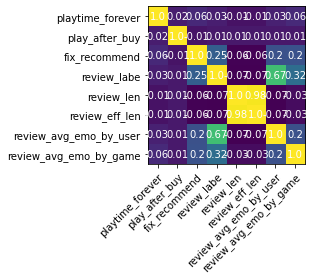

In [24]:
import matplotlib as mpl

x_label = ['playtime_forever','play_after_buy','fix_recommend','review_labe',
'review_len','review_eff_len','review_avg_emo_by_user','review_avg_emo_by_game']

fig, ax = plt.subplots()
im = ax.imshow(coeff)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(x_label)), labels=x_label)
ax.set_yticks(np.arange(len(x_label)), labels=x_label)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(x_label)):
    for j in range(len(x_label)):
        text = ax.text(j, i, round(coeff[i, j],2),
                       ha="center", va="center", color="w")

# ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

In [25]:
y = data_np_new[:,5]
X = np.hstack((data_np_new[:,6:7],data_np_new[:,9:11]))


In [26]:
len(X[0])

3

In [79]:
def splitData(X, y, p1, p2, balance=False): 
    X = np.array(X)
    y = np.array(y)

    if balance:
        total = len(y)
        n = round(len(y)*p1/2)

        idx = []
        while len(idx) < n:
            i = random.choice(range(total))
            if y[i] == 1:
                idx.append(i)
        X_test = X[idx]
        y_test = y[idx]
        X = np.delete(X, idx, 0)
        y = np.delete(y, idx, 0)
        
        idx = []
        total = len(y)
        while len(idx) < n:
            i = random.choice(range(total))
            if y[i] == 0:
                idx.append(i)
        X_test = np.concatenate((X_test,X[idx]), axis=0)
        y_test = np.concatenate((y_test,y[idx]), axis=0)
        X = np.delete(X, idx, 0)
        y = np.delete(y, idx, 0)

    else:
        sss = StratifiedShuffleSplit(n_splits=5, test_size=p1)
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        X = X_train
        y = y_train

    sss = StratifiedShuffleSplit(n_splits=5, test_size=p2)
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]

    print(len(y_train), len(y_valid), len(y_test))
    print(sum([len(y_train), len(y_valid), len(y_test)]))
    return X_train, y_train, X_valid, y_valid, X_test, y_test
    

In [80]:
labels = data['fix_recommend'].to_list()

In [193]:
data_train, y_train, data_valid, y_valid, data_test, y_test = splitData(data, labels, .1, .15, True)

34175 6031 4416
44622


In [165]:
data_train[0]

array(['immunity', 205100, 1497, True,
       'Strong contender for game of the year 2012, Dishonored utilizes a fantastic universe and exceptional gameplay to tell the revenge tale of Corvo Attano.The game is exceptionally opened giving the player true customization over how they wish to achieve their task which typically revolve around disposing (fatally or not) of key targets. The really appealing aspect of the game is each area is fairly open giving the player the choice on how they wish to achieve their task, which can range from stealhy sewer trecking utilizing magic to not be seen and non-lethally deal with targets or a more confronting method in which you unleash swarms of rats and shoot foes in the face.The setting of the game is also extremely cool. The city of dunwall is full of steampunk achievements, plague carrying rats and victims known as weepers and a secretive occult to the enimatic Outsider.Buy This Game.',
       True, 1], dtype=object)

### Index:

0:  user_id	
1:  item_id	
2:  playtime_forever	
3:  play_after_buy	
4:  review	
5:  fix_recommend	
6:  review_label

In [ ]:
# idx = []
# X_train = data

In [53]:
X_train, y_train, X_valid, y_valid, X_test, y_test = splitData(X, y, .1, .15, True)
X_train = X_train.tolist()
y_train = y_train.tolist()
X_valid = X_valid.tolist()
y_valid = y_valid.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()

34209 6037 4416
44662


In [59]:
def evaluate(y1,y2):
    TN, FP, FN, TP = confusion_matrix(y1,y2).ravel()
    BER = (FP/(TN+FP) + FN/(FN+TP))/2
    PREC = TP/(TP+FP)
    RECALL = TP/(TP+FN)
    F1 = 2*(PREC*RECALL)/(PREC+RECALL)
    acc = accuracy_score(y1,y2)
    return TN, FP, FN, TP,BER,PREC,RECALL,F1,acc


In [56]:
c_list = [1e-3,1e-2,1e-1,1,10]
valid_res = []
for c in c_list:
    # 记得再考虑 balance！！！！
    reg = linear_model.LogisticRegression(C=c, random_state=0, class_weight='balanced').fit(X_train, y_train)
    y1_valid = reg.predict(X_valid)
    TN1_valid, FP1_valid, FN1_valid, TP1_valid, \
    BER1_valid,PREC1_valid,RECALL1_valid,F11_valid,acc1_valid = evaluate(y_valid,y1_valid)
    valid_res.append((F11_valid,acc1_valid,BER1_valid,PREC1_valid,RECALL1_valid,c))


In [57]:
np.asarray(valid_res)

array([[9.05798461e-01, 8.33692231e-01, 3.47701544e-01, 9.47957581e-01,
        8.67229608e-01, 1.00000000e-03],
       [8.98619255e-01, 8.22428358e-01, 3.46036140e-01, 9.48682109e-01,
        8.53575278e-01, 1.00000000e-02],
       [8.84874111e-01, 8.01557065e-01, 3.36948321e-01, 9.51239669e-01,
        8.27164930e-01, 1.00000000e-01],
       [8.82914137e-01, 7.98741097e-01, 3.32645010e-01, 9.52192891e-01,
        8.23032699e-01, 1.00000000e+00],
       [8.82483370e-01, 7.98078516e-01, 3.33004334e-01, 9.52153110e-01,
        8.22314050e-01, 1.00000000e+01]])

In [60]:
c_list = [1e-3,1e-2,1e-1,1,10]
valid_res = []
for c in c_list:
    # 记得再考虑 balance！！！！
    reg = linear_model.LogisticRegression(C=c, random_state=0).fit(X_train, y_train)
    y1_valid = reg.predict(X_valid)
    TN1_valid, FP1_valid, FN1_valid, TP1_valid, \
    BER1_valid,PREC1_valid,RECALL1_valid,F11_valid,acc1_valid = evaluate(y_valid,y1_valid)
    valid_res.append((F11_valid,acc1_valid,BER1_valid,PREC1_valid,RECALL1_valid,c))
np.asarray(valid_res)

array([[9.59407050e-01, 9.21981116e-01, 5.00000000e-01, 9.21981116e-01,
        1.00000000e+00, 1.00000000e-03],
       [9.59407050e-01, 9.21981116e-01, 5.00000000e-01, 9.21981116e-01,
        1.00000000e+00, 1.00000000e-02],
       [9.58286553e-01, 9.19993374e-01, 4.95247533e-01, 9.22667554e-01,
        9.96766080e-01, 1.00000000e-01],
       [9.58444924e-01, 9.20324665e-01, 4.92152651e-01, 9.23115327e-01,
        9.96586418e-01, 1.00000000e+00],
       [9.58444924e-01, 9.20324665e-01, 4.92152651e-01, 9.23115327e-01,
        9.96586418e-01, 1.00000000e+01]])

Evaluate test set

In [62]:
c_best = 1e-3

reg = linear_model.LogisticRegression(C=c, random_state=0, class_weight='balanced').fit(X_train, y_train)

y1_test = reg.predict(X_test)
TN1_test, FP1_test, FN1_test, TP1_test, \
BER1_test,PREC1_test,RECALL1_test,F11_test,acc1_test = evaluate(y_test,y1_test)
print((F11_test,acc1_test,BER1_test,PREC1_test,RECALL1_test))

(0.7109173766594016, 0.6696105072463768, 0.33038949275362317, 0.63191264529764, 0.8125)


In [77]:
# y1_test = reg.predict(X_test)
# TN, FP, FN, TP = confusion_matrix(y_test,y1_test).ravel()
# BER = (FP/(TN+FP) + FN/(FN+TP))/2
# PREC = TP/(TP+FP)
# RECALL = TP/(TP+FN)
# F1 = 2*(PREC*RECALL)/(PREC+RECALL)

# acc1_test = getAcc(y1_test,y_test)
# acc1_test

########################################
#              test 再写！！！           #
########################################

0.8908761602897894

In [150]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                             n_informative=2, n_redundant=0,
#                             random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
RandomForestClassifier(...)


RandomForestClassifier(n_estimators=Ellipsis)

In [ ]:
y2_valid = clf.predict(X_valid)
acc2_valid = getAcc(y2_valid,y_valid)
acc2_valid

In [83]:
y2_test = clf.predict(X_test)
acc2_test = getAcc(y2_test,y_test)
acc2_test

0.8888385782205117

### Index:

0:  user_id	
1:  item_id	
2:  playtime_forever	
3:  play_after_buy	
4:  review	
5:  fix_recommend	
6:  review_label

XN's work:

In [203]:
def resample(X, y):
    idx_0 = [i for i in range(len(y)) if y[i]==0]
    idx_1 = [i for i in range(len(y)) if y[i]==1]
    # print(len(idx_0), len(idx_1))

    new_idx_1 = []
    for _ in range(len(idx_0)):
        new_idx_1.append(random.choice(idx_1))

    idx_0 += new_idx_1
    random.shuffle(idx_0)
    X_sampled = X[idx_0]
    y_sampled = y[idx_0]

    return X_sampled, y_sampled

def addNegsample(X,y,df):
    df = df.to_numpy()
    y = y.tolist()
    X = X.tolist()
    n = sum(y)
    print(n)
    while len(y) < 2*n:
        i = random.choice(range(len(df)))
        if df[i,2] == 0:
            y.append(False)
            X.append(df[i,:])
    
    return X, y
    



In [183]:
df = pd.read_csv('user_item_playtime.csv')
df.head(5)

,user_id,item_id,playtime_forever
0,76561197970982479,10,6
1,76561197970982479,20,0
2,76561197970982479,30,7
3,76561197970982479,40,0
4,76561197970982479,50,0


In [167]:
idx = [0,1,5]

In [205]:
X_train = data_train[:,idx]
X_valid = data_valid[:,idx]
X_test = data_test[:,idx]

In [206]:
X_train, y_train = addNegsample(X_train,y_train,df)
X_valid, y_valid = addNegsample(X_valid,y_valid,df)

31540
5566


In [181]:
resample = 0
if resample:
    X_train,y_train = resample(X_train,y_train)
    # len(y_train)
    X_valid,y_valid = resample(X_valid,y_valid)


In [207]:
timePerUser = defaultdict(list)
timePerItem = defaultdict(list)
for u,i,t in X_train:
    timePerUser[u].append((i,t))
    timePerItem[i].append((u,t))

In [208]:
N = len(X_train)
nUsers = len(timePerUser)
nItems = len(timePerItem)
users = list(timePerUser.keys())
items = list(timePerItem.keys())

In [209]:
alpha = np.mean(y_train)
userBiases = defaultdict(float)
itemBiases = defaultdict(float)

### beta+gamma

In [157]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

def prediction(user, item):
    global userGamma
    global itemGamma
    return alpha + userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])

def unpack(theta):
    global K
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K

def cost(theta, labels, lamb):
    global K
    unpack(theta)
    predictions = [prediction(d[0], d[1]) for d in X_train]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost

def derivative(theta, labels, lamb):
    global K
    unpack(theta)
    N = len(X_train)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in timePerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in timePerItem:
        dItemGamma[i] = [0.0 for k in range(K)]
    for d in X_train:
        u,i = d[0], d[1]
        pred = prediction(u, i)
        diff = pred - int(d[2])
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return numpy.array(dtheta)

In [211]:
K = 0
lamb = 1e-5
iter = 100

userGamma = {}
itemGamma = {}

for u in timePerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in timePerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + # Initialize alpha
                                   [0.0]*(nUsers+nItems) + # Initialize beta
                                   [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))], # Gamma
                             derivative, 
                             args=(y_train, lamb), 
                             maxiter=iter, 
                             epsilon=1e-8)

MSE = 0.27299874683015823
MSE = 0.9387856935223099
MSE = 0.24827855376190375
MSE = 0.24696904303471917
MSE = 0.24203843491335678
MSE = 0.20401617698221117
MSE = 0.19051608795499564
MSE = 0.16578758508355074
MSE = 0.1592925554732221
MSE = 0.14568848653574823
MSE = 0.1412438573069033
MSE = 0.13543719323542155
MSE = 0.12738143647747724
MSE = 0.11640323340759229
MSE = 0.11150711856003241
MSE = 0.10570460766915604
MSE = 0.16303808220984692
MSE = 0.10560120711884526
MSE = 0.10425934522009593
MSE = 0.10233264137159243
MSE = 0.10060320654835476
MSE = 0.09649338163212988
MSE = 0.09367356018327741
MSE = 0.09016181737015579
MSE = 0.08767415565003057
MSE = 0.08472309871399196
MSE = 0.08137969223683042
MSE = 0.07998211277271643
MSE = 0.07898579252272679
MSE = 0.07589956267717483
MSE = 0.14310092689974113
MSE = 0.07583124630054423
MSE = 0.07481890910484065
MSE = 0.07417741148585354
MSE = 0.07305297376091087
MSE = 0.07198791240631615
MSE = 0.07095348827820226
MSE = 0.07045476826769846
MSE = 0.0691403

(array([ 0.34734307,  0.2075853 ,  0.18298128, ..., -0.08458948,
        -0.13940507, -0.12373129]),
 0.07236257082021948,
 {'grad': array([-9.33141348e-04,  1.94066588e-08,  2.73011060e-07, ...,
         -1.11043220e-06, -6.15211641e-07,  5.22633184e-07]),
  'task': 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT',
  'funcalls': 115,
  'nit': 100,
  'warnflag': 1})

In [ ]:
def prepare(Train):
    item0Count = defaultdict(int)
    item1Count = defaultdict(int)
    total0 = 0
    total1 = 0
    item0PerUser = defaultdict(set)
    item1PerUser = defaultdict(set)
    userPerItem0 = defaultdict(set)
    userPerItem1 = defaultdict(set)
    item0Set = set()
    item1Set = set()

    for u,i,p in Train:    
        if int(p):
            item1Count[i] += 1
            total1 += 1
            item1Set.add(i)
            item1PerUser[u].add(i)
            userPerItem1[i].add(u)
        else:
            item0Count[i] += 1
            total0 += 1
            item0Set.add(i)
            item0PerUser[u].add(i)
            userPerItem0[i].add(u)
            
    mostPopular0 = [(item0Count[x], x) for x in item0Count]
    mostPopular1 = [(item1Count[x], x) for x in item1Count]
    mostPopular0.sort()
    mostPopular0.reverse()
    mostPopular1.sort()
    mostPopular1.reverse()

    return mostPopular0, mostPopular1, item0PerUser, item1PerUser, userPerItem0, userPerItem1

In [212]:
mostPopular0, mostPopular1, game0PerUser, game1PerUser, userPerGame0, userPerGame1 = prepare(X_train)

In [176]:
def Jaccard(s1, s2):
    return len(s1.intersection(s2))/len(s1.union(s2))
def getPred(X, thres1, output=False):
    yPred = []
    n = round(min([len(set(mostPopular0)), len(set(mostPopular1))])*thres1)
    intersection = set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])
    popularSet0 = set([x[1] for x in mostPopular0[:n]]) - intersection
    popularSet1 = set([x[1] for x in mostPopular1[:n]]) - intersection
    # print(X)
    # l = len(X)
    # cnt = 0
    for u,i,_ in X:
        # cnt += 1

        if i in popularSet0:
            yPred.append(0)
            continue
        
        if i in popularSet1:
            yPred.append(1)
            continue
        
        maxSimilarity0 = 0
        gSet = set(userPerGame0[i])
        for g_prime in game0PerUser[u]:
            g_priSet = set(userPerGame0[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity0 = max(maxSimilarity0, similarity)
        
        maxSimilarity1 = 0
        gSet = set(userPerGame1[i])
        for g_prime in game1PerUser[u]:
            g_priSet = set(userPerGame1[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity1 = max(maxSimilarity1, similarity)
        # print(maxSimilarity0 , maxSimilarity1)
        if maxSimilarity0 > maxSimilarity1:
            yPred.append(0)
            continue
      
        yPred.append(1)
        # cnt += 1

        # if output and cnt%1000 == 0:
        #     print(cnt, '/', l)
    # print(cnt,'/',l)
    return yPred

In [213]:
yPred = []
for u,i,r in X_valid:
    try:
        yPred.append(prediction(u,i))
    except:
        yPred.append(alpha)

validMSE = MSE(yPred,y_valid)
print('MSE: ', validMSE)

cnt = 0
y_pred = []
for u,i,r in X_valid:
    try:
        pred = prediction(u, i)
        cnt += 1
    except:
        pred = getPred([(u,i,0)], .3)[0]
    y_pred.append(round(pred))
    
acc = accuracy_score(y_valid, y_pred)

print(cnt,'/',len(X_valid))
print('acc: ', acc)

MSE:  0.1667851309579454
8328 / 11132
acc:  0.766798418972332


In [178]:
userBiases

{'23434454365463446754546576e45646': 0.4606222074487144,
 'BBBirb': 0.6454613014418814,
 'mistersicklad483759': 0.3886064141726273,
 'Assasindie': -0.04740406089245292,
 '76561198014421677': -0.2322952069314209,
 '76561198024701418': 0.9808507015132067,
 'ThereSheBlows': -0.36855696875389427,
 'ducksswamp': 0.17147837735685817,
 '76561198073343567': 0.2261930785967564,
 '76561198044036045': 0.08238235442717445,
 '76561198099905142': 0.15317063633598912,
 'benjaminalan': -0.2322952069314209,
 'BOBROSSJPEGEXE': 0.3466468520070228,
 '76561198084300729': -0.5735559653836055,
 '76561198023009163': 0.670558553180661,
 'NEEDforSHEEP': -0.2520423340346623,
 'Crackleking76': 0.4007596932111879,
 '--ace--': 0.001731844931258631,
 'Matt4Prez2K16': -0.2322952069314209,
 'superkingofthings': -0.18155873643830917,
 'SMIGDEEK': -0.17839712652237616,
 'Mister_Mad': -0.1563429618536906,
 'nyclix': 0.31681337353638184,
 'manuelpr039': 0.0094349233520662,
 'AgrarianSkyX': -0.008396757228642023,
 'Nananan

In [23]:
itemBiases_list = [(itemBiases[x], x) for x in itemBiases]
itemBiases_list.sort()
itemBiases_list.reverse()
itemBiases_list

[(0.7062188395938781, '397430'),
 (0.665728727724407, '321060'),
 (0.648946371008936, '241560'),
 (0.6476472135647715, '370150'),
 (0.6406238122370997, '331190'),
 (0.6342363472166902, '250110'),
 (0.6225263659336288, '251610'),
 (0.621948634880526, '97330'),
 (0.6133136907855307, '410320'),
 (0.6089863720310469, '299740'),
 (0.6069887692645608, '412880'),
 (0.6067580141979335, '391730'),
 (0.601436684746111, '263280'),
 (0.5978701813218229, '244210'),
 (0.5978203156227191, '319550'),
 (0.5945260116744197, '298030'),
 (0.592311739065862, '337000'),
 (0.5913692743392581, '346010'),
 (0.5897460365836508, '434570'),
 (0.5831354923785829, '268500'),
 (0.5828207396981485, '730'),
 (0.5774346479569326, '403700'),
 (0.5770957623224943, '227320'),
 (0.5757396413905522, '251570'),
 (0.5749832437179667, '221100'),
 (0.5746335625904619, '252490'),
 (0.5740288763687891, '211820'),
 (0.5692736977054095, '250900'),
 (0.5686733372773399, '39210'),
 (0.568574305471497, '308420'),
 (0.5685327590407189,

In [214]:
cnt = 0
y_pred = []
for u,i,r in X_test:
    try:
        pred = prediction(u, i)
        cnt += 1
    except:
        # pred = alpha
        pred = getPred([(u,i,0)], .3)[0]
    y_pred.append(round(pred))
    
acc = accuracy_score(y_test, y_pred)

print(cnt,'/',len(X_test))
print('acc: ', acc)

3521 / 4416
acc:  0.5765398550724637


### PlayafterBuy or NOT

In [389]:
def readCSV2(path):
    with open(path, encoding="utf8") as f:
        f.readline()
        for l in f:
            u,i,_,p,_ = l.strip().split(',')
            p = 1 if p == 'True' else 0
            yield u,i,p

In [14]:
def Jaccard(s1, s2):
    return len(s1.intersection(s2))/len(s1.union(s2))

In [13]:
def prepare(Train):
    item0Count = defaultdict(int)
    item1Count = defaultdict(int)
    total0 = 0
    total1 = 0
    item0PerUser = defaultdict(set)
    item1PerUser = defaultdict(set)
    userPerItem0 = defaultdict(set)
    userPerItem1 = defaultdict(set)
    item0Set = set()
    item1Set = set()

    for u,i,p in Train:    
        if int(p):
            item1Count[i] += 1
            total1 += 1
            item1Set.add(i)
            item1PerUser[u].add(i)
            userPerItem1[i].add(u)
        else:
            item0Count[i] += 1
            total0 += 1
            item0Set.add(i)
            item0PerUser[u].add(i)
            userPerItem0[i].add(u)
            
    mostPopular0 = [(item0Count[x], x) for x in item0Count]
    mostPopular1 = [(item1Count[x], x) for x in item1Count]
    mostPopular0.sort()
    mostPopular0.reverse()
    mostPopular1.sort()
    mostPopular1.reverse()

    return mostPopular0, mostPopular1, item0PerUser, item1PerUser, userPerItem0, userPerItem1

In [391]:
playX = []
for l in readCSV2('user_item_review_merge_table.csv'):
    playX.append(l)
len(playX)

5154633

In [392]:
n = 800000
random.shuffle(playX)
playX = playX[:n]


In [393]:
playy = [t for _,_,t in playX]

In [394]:
X_train, y_train, X_valid, y_valid, X_test, y_test = splitData(playX, playy, .1, .15)

612000 108000 80000


In [395]:
mostPopular0, mostPopular1, game0PerUser, game1PerUser, userPerGame0, userPerGame1 = prepare(X_train)

In [396]:
len(set(mostPopular0)), len(set(mostPopular1))

(7528, 7412)

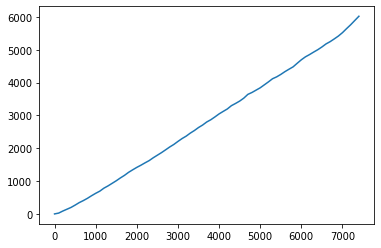

In [397]:
x = [i for i in range(1, min([len(set(mostPopular0)), len(set(mostPopular1))]), 100)]
y = []
for n in x:
    y.append(len(set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])))

plt.plot(x,y)

In [15]:
def getPred(X, thres1, output=False):
    yPred = []
    n = round(min([len(set(mostPopular0)), len(set(mostPopular1))])*thres1)
    union = set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])
    popularSet0 = set([x[1] for x in mostPopular0[:n]]) - union
    popularSet1 = set([x[1] for x in mostPopular1[:n]]) - union

    l = len(X)
    cnt = 0
    for u,i,_ in X:
        cnt += 1

        if i in popularSet0:
            yPred.append(0)
            continue
        
        if i in popularSet1:
            yPred.append(1)
            continue
        
        maxSimilarity0 = 0
        gSet = set(userPerGame0[i])
        for g_prime in game0PerUser[u]:
            g_priSet = set(userPerGame0[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity0 = max(maxSimilarity0, similarity)
        
        maxSimilarity1 = 0
        gSet = set(userPerGame1[i])
        for g_prime in game1PerUser[u]:
            g_priSet = set(userPerGame1[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity1 = max(maxSimilarity1, similarity)
        # print(maxSimilarity0 , maxSimilarity1)
        if maxSimilarity0 > maxSimilarity1:
            yPred.append(0)
            continue
      
        yPred.append(1)

        if output and cnt%1000 == 0:
            print(cnt, '/', l)

    return yPred

In [399]:
thres1 = .025
pred = getPred(X_valid, thres1, output=True)

3000 / 108000
4000 / 108000
6000 / 108000
8000 / 108000
10000 / 108000
13000 / 108000
15000 / 108000
18000 / 108000
22000 / 108000
27000 / 108000
29000 / 108000
31000 / 108000
33000 / 108000
34000 / 108000
35000 / 108000
36000 / 108000
37000 / 108000
39000 / 108000
41000 / 108000
45000 / 108000
50000 / 108000
51000 / 108000
55000 / 108000
56000 / 108000
57000 / 108000
60000 / 108000
61000 / 108000
62000 / 108000
63000 / 108000
64000 / 108000
65000 / 108000
67000 / 108000
69000 / 108000
70000 / 108000
71000 / 108000
73000 / 108000
77000 / 108000
80000 / 108000
83000 / 108000
85000 / 108000
91000 / 108000
93000 / 108000
95000 / 108000
97000 / 108000
98000 / 108000
101000 / 108000
102000 / 108000
104000 / 108000
107000 / 108000
108000 / 108000


In [400]:
acc = metrics.accuracy_score(y_valid, pred)
TN, FP, FN, TP = confusion_matrix(y_valid, pred).ravel()
print('acc: ', acc)
print('TN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres1)

acc:  0.7426111111111111
TN:  26770 FP: 12376 FN:  15422 TP:  53432  |  thres:  0.025


In [403]:
thresLst = [.01,.05,.1,.3,.5,.7,.9]
print('-'*30+'PlayafterBuy or NOT'+'-'*30)
for thres in thresLst:
    pred = getPred(X_valid, thres)
    acc = metrics.accuracy_score(y_valid, pred)
    TN, FP, FN, TP = confusion_matrix(y_valid, pred).ravel()
    print('Acc: ', acc)
    print('TN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres)


------------------------------PlayafterBuy or NOT------------------------------
Acc:  0.737175925925926
TN:  27315 FP: 11831 FN:  16554 TP:  52300  |  thres:  0.01
Acc:  0.7420925925925926
TN:  25465 FP: 13681 FN:  14173 TP:  54681  |  thres:  0.05
Acc:  0.740574074074074
TN:  24363 FP: 14783 FN:  13235 TP:  55619  |  thres:  0.1
Acc:  0.7303240740740741
TN:  24038 FP: 15108 FN:  14017 TP:  54837  |  thres:  0.3
Acc:  0.7245462962962963
TN:  23969 FP: 15177 FN:  14572 TP:  54282  |  thres:  0.5
Acc:  0.7228240740740741
TN:  23967 FP: 15179 FN:  14756 TP:  54098  |  thres:  0.7
Acc:  0.7223611111111111
TN:  24019 FP: 15127 FN:  14858 TP:  53996  |  thres:  0.9


In [262]:
thres = .05
pred = getPred(X_test, thres)
acc = metrics.accuracy_score(y_test, pred)
TN, FP, FN, TP = confusion_matrix(y_test, pred).ravel()
print('acc: ', acc)
print('TN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres)

acc:  0.73302
TN:  11054 FP: 7067 FN:  6282 TP:  25597  |  thres:  0.05


### Recommend or NOT

In [4]:
def readCSV3(path):
    with open(path, encoding="utf8") as f:
        f.readline()
        for l in f:
            u,i,_,r = l.strip().split(',')
            r = 1 if r == 'True' else 0
            yield u,i,r

In [7]:
def readCSV4(path):
    with open(path, encoding="utf8") as f:
        f.readline()
        for l in f:
            u,i,_,_,r = l.strip().split(',')
            r = 1 if r == 'True' else 0
            yield u,i,r

In [8]:
recX = []
recy = []
# for l in readCSV3('merge_table_drop_na.csv'):
for l in readCSV4('recommend.csv'):
    recX.append(l)
    recy.append(l[2])
len(recy)

1914191

In [27]:
n = sum(recy)
new_X = [x for x in recX if x[2]==1]
all_y = [x for x in recX if x[2]==0]
for i in range(len(new_X)):
    new_X.append(random.choice(all_y))

In [30]:
new_y = [x[2] for x in new_X]

In [34]:
recX, recy = new_X, new_y

In [35]:
X_train, y_train, X_valid, y_valid, X_test, y_test = splitData(recX, recy, .1, .15)

62992 11117 8235


In [32]:
X_train

array([['bohemianknight', '204030', '0'],
       ['76561198039746024', '6020', '0'],
       ['Pickles_was_here', '730', '1'],
       ...,
       ['76561198079079942', '8000', '0'],
       ['worldtradecentre', '211820', '1'],
       ['76561198059286499', '50', '0']], dtype='<U32')

In [36]:
sum(np.array(recy))/len(recy)

0.5

In [37]:
mostPopular0, mostPopular1, game0PerUser, game1PerUser, userPerGame0, userPerGame1 = prepare(X_train)

In [38]:
len(set(mostPopular0)), len(set(mostPopular1))

(4517, 2504)

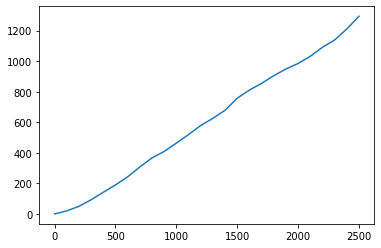

In [39]:
x = [i for i in range(1, min([len(set(mostPopular0)), len(set(mostPopular1))]), 100)]
y = []
for n in x:
    y.append(len(set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])))

plt.plot(x,y)

In [40]:
thresLst = [.01,.05,.1,.3,.5,.7,.9]
print('-'*30+'Recommend or NOT'+'-'*30)
for thres in thresLst:
    pred = getPred(X_valid, thres)
    acc = metrics.accuracy_score(y_valid, pred)
    TN, FP, FN, TP = confusion_matrix(y_valid, pred).ravel()
    print('acc: ', acc)
    print('TN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres)

------------------------------Recommend or NOT------------------------------
acc:  0.5951245839704956
TN:  1147 FP: 4411 FN:  90 TP:  5469  |  thres:  0.01
acc:  0.6406404605559054
TN:  1769 FP: 3789 FN:  206 TP:  5353  |  thres:  0.05
acc:  0.6669964918593145
TN:  2055 FP: 3503 FN:  199 TP:  5360  |  thres:  0.1
acc:  0.6891247638751462
TN:  2251 FP: 3307 FN:  149 TP:  5410  |  thres:  0.3
acc:  0.6866060987676531
TN:  2229 FP: 3329 FN:  155 TP:  5404  |  thres:  0.5
acc:  0.6819285778537375
TN:  2183 FP: 3375 FN:  161 TP:  5398  |  thres:  0.7
acc:  0.6837276243590897
TN:  2203 FP: 3355 FN:  161 TP:  5398  |  thres:  0.9
